In [1]:
import tensorflow as tf
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

2024-01-18 11:44:10.893304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Define paths to your training and testing directories
train_dir = 'Datasets/FER2013/train'
test_dir = 'Datasets/FER2013/test'
# Set the image size and batch size
image_size = (48, 48)
batch_size = 32

# Create an ImageDataGenerator for data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # Normalize pixel values
    horizontal_flip=True,  # Augmentation: horizontal flip
    # zoom_range=0.0,  # Augmentation: zoom (with current dataset not needed, since faces are centered)
    # rotation_range=10,  # Augmentation: rotation
    # width_shift_range=0.05,  # Augmentation: width shift (only 5% since faces are centered)
    # height_shift_range=0.05  # Augmentation: height shift (only 5% since faces are centered)
)

test_datagen = ImageDataGenerator(rescale=1. / 255)  # Only rescaling for test data

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,  # Resize images to (48, 48) for uniformity
    batch_size=batch_size,  # Batch size for training
    color_mode='grayscale',  # FER-2013 images are grayscale
    class_mode='categorical'  # For multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


train_generator and test_generator are now ready to be used in model training and evaluation

In [9]:
# Define the model
model = Sequential()

# First Conv Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Second Conv Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Third Conv Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # Assuming 7 emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 64)       

In [10]:
# Number of epochs to train for
epochs = 10

# Steps per epoch (usually the number of samples in the training set divided by the batch size)
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Validation steps (usually the number of samples in the validation set divided by the batch size)
validation_steps = test_generator.samples // test_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps
)

Epoch 1/10
897/897 [==============================] - 53s 58ms/step - loss: 1.7845 - accuracy: 0.2669 - val_loss: 1.6465 - val_accuracy: 0.3313
Epoch 2/10
897/897 [==============================] - 53s 60ms/step - loss: 1.6390 - accuracy: 0.3505 - val_loss: 1.5435 - val_accuracy: 0.4308
Epoch 3/10
897/897 [==============================] - 56s 63ms/step - loss: 1.5373 - accuracy: 0.3990 - val_loss: 1.4217 - val_accuracy: 0.4672
Epoch 4/10
897/897 [==============================] - 110s 123ms/step - loss: 1.4717 - accuracy: 0.4281 - val_loss: 1.3593 - val_accuracy: 0.4821
Epoch 5/10
897/897 [==============================] - 56s 62ms/step - loss: 1.4255 - accuracy: 0.4502 - val_loss: 1.3096 - val_accuracy: 0.5000
Epoch 6/10
897/897 [==============================] - 60s 67ms/step - loss: 1.4067 - accuracy: 0.4625 - val_loss: 1.2790 - val_accuracy: 0.5152
Epoch 7/10
897/897 [==============================] - 109s 121ms/step - loss: 1.3780 - accuracy: 0.4745 - val_loss: 1.2702 - val_accur

225/225 [==============================] - 56s 248ms/step - loss: 1.2278 - accuracy: 0.5300
Test accuracy:  0.5299526453018188
225/225 [==============================] - 48s 208ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.06      0.09      1024
       happy       0.24      0.30      0.27      1774
     neutral       0.17      0.22      0.19      1233
         sad       0.19      0.18      0.19      1247
    surprise       0.11      0.12      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.18      7178


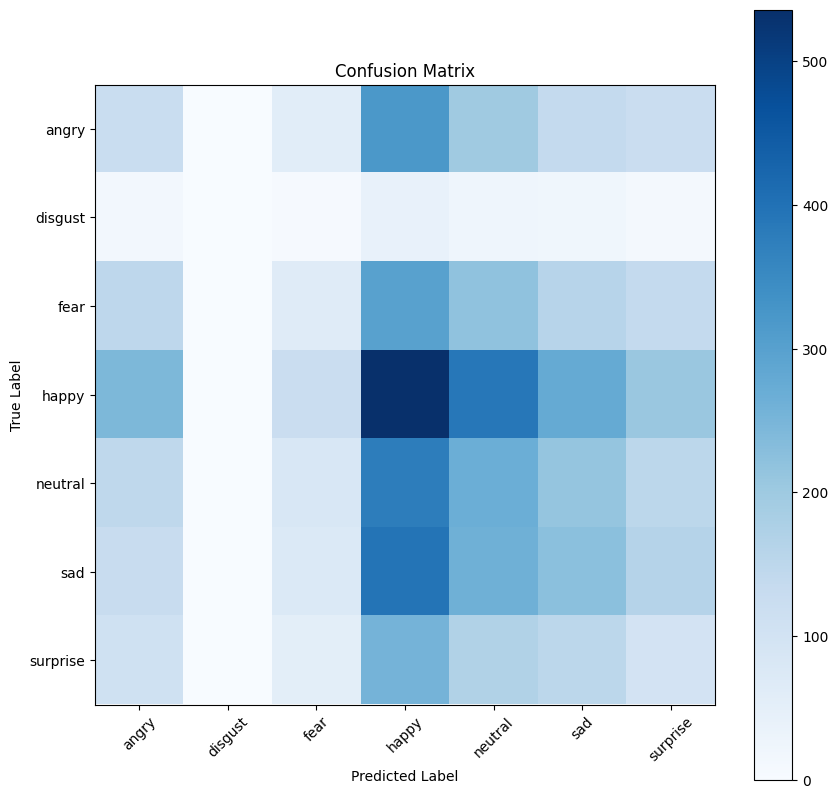

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Since the generator omits some samples due to rounding down in 'steps', we trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making